In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import schedulers

from time import perf_counter

import pandas as pd
import numpy as np

from superonn_final import SuperONN2d, randomshift, SuperONNTranpose2d
from superonn_final_1d import SuperONN1d, randomshift_1d, SuperONNTranpose1d

import matplotlib.pyplot as plt

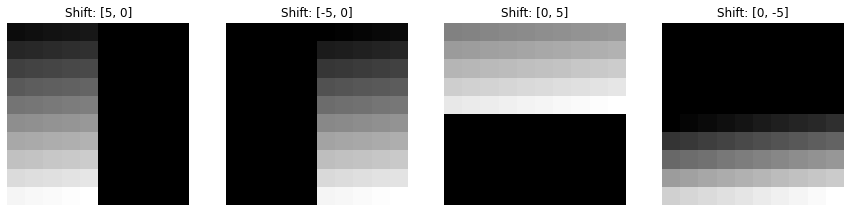

In [2]:
x = torch.arange(100).view(1,1,10,10).repeat(1,4,1,1) / 100
shifts = torch.tensor([[5, 0], [-5, 0], [0, 5], [0, -5]])
y = randomshift(x, shifts, learnable=False, max_shift=10, rounded_shifts=False, padding_mode='zeros')

plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(y[0,i], cmap='gray')
    plt.axis('off')
    plt.title(f'Shift: {shifts[i].tolist()}')

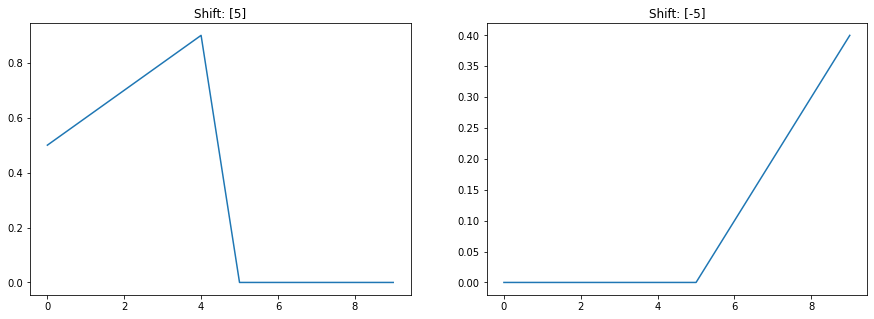

In [45]:
x = torch.arange(10).view(1,1,10).repeat(1,2,1) / 10
shifts = torch.tensor([[5], [-5]])
y = randomshift_1d(x, shifts, learnable=False, max_shift=10, rounded_shifts=False, padding_mode='zeros')

plt.figure(figsize=(15, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(y[0,i])
    plt.gca().patch.set_alpha(0)
    plt.title(f'Shift: {shifts[i].tolist()}')

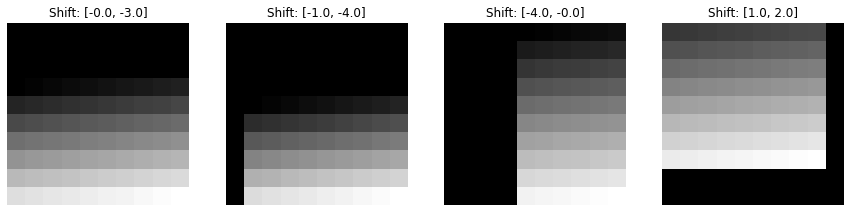

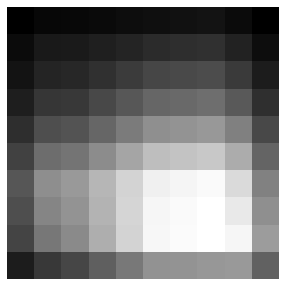

In [102]:
x = torch.arange(100).view(1,1,10,10).repeat(1,4,1,1) / 100
sonn2d = SuperONN2d(4, 1, q=1, kernel_size=3, padding=1, max_shift=10, shift_init='half_int', shift_groups=4)
nn.init.ones_(sonn2d.weight)
nn.init.zeros_(sonn2d.bias)
shifted_x = randomshift(x, sonn2d.shifts.squeeze(0) * 10, learnable=False, max_shift=10, rounded_shifts=False, padding_mode='zeros')
y = sonn2d(x).detach()
y = y / y.max()

plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(shifted_x[0,i], cmap='gray')
    plt.axis('off')
    plt.title(f'Shift: {sonn2d.shifts.squeeze(0)[i].mul(10).tolist()}')

plt.figure(figsize=(15, 5))
for i in range(1):
    plt.subplot(1, 1, i+1)
    plt.imshow(y[0,i], cmap='gray')
    plt.axis('off')

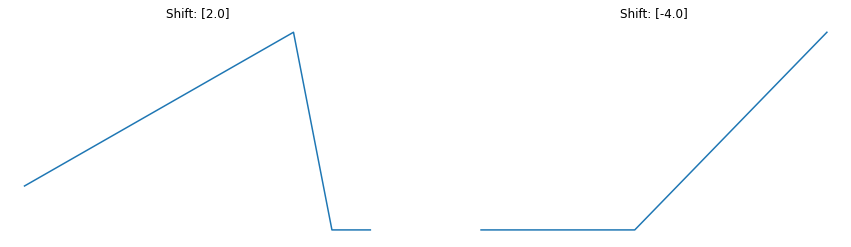

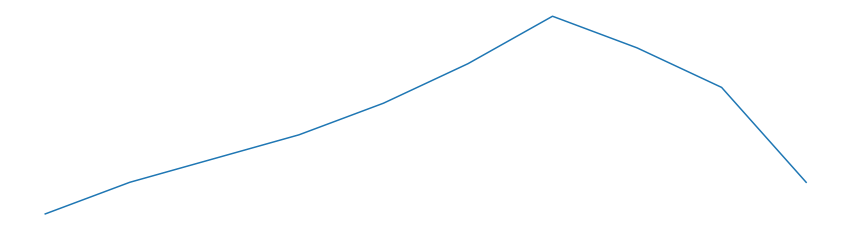

In [101]:
x = torch.arange(10).view(1,1,10).repeat(1,2,1) / 10
sonn1d = SuperONN1d(2, 1, q=1, kernel_size=3, padding=1, max_shift=10, shift_init='half_int', shift_groups=2)
nn.init.ones_(sonn1d.weight)
nn.init.zeros_(sonn1d.bias)
shifted_x = randomshift_1d(x, sonn1d.shifts.squeeze(0) * 10, learnable=False, max_shift=10, rounded_shifts=False, padding_mode='zeros')
y = sonn1d(x).detach()
y = y / y.max()

plt.figure(figsize=(15, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(shifted_x[0,i])
    plt.axis('off')
    plt.title(f'Shift: {sonn1d.shifts.squeeze(0)[i].mul(10).tolist()}')

plt.figure(figsize=(15, 4))
for i in range(1):
    plt.subplot(1, 1, i+1)
    plt.plot(y[0,i])
    plt.axis('off')

In [3]:
def calculate_output_padding(n, k, p, s, d):
    n_hat = (n + 2 * p - d * (k - 1) - 1) // s + 1  # size after conv
    n_tpd = (n_hat - 1) * s - 2 * p + d * (k - 1) + 1   # size after transposed conv
    op = n - n_tpd  # output padding
    print(n, n_hat, n_tpd, op)
    return op

In [4]:
n = 16
k = 5
p = 2
s = 3
d = 1
op = calculate_output_padding(n, k, p, s, d)

x = torch.arange(n**2).view(1,1,n,n) / n**2
print(x.shape)
conv2d = nn.Conv2d(1, 3, kernel_size=k, padding=p, stride=s, dilation=d)
print('W', conv2d.weight.shape)
y = conv2d(x).detach()
print(y.shape)

convt2d = nn.ConvTranspose2d(3, 1, kernel_size=k, padding=p, stride=s, dilation=d, output_padding=op)
print('W', convt2d.weight.shape)
z = convt2d(y).detach()
print(z.shape)

16 6 16 0
torch.Size([1, 1, 16, 16])
W torch.Size([3, 1, 5, 5])
torch.Size([1, 3, 6, 6])
W torch.Size([3, 1, 5, 5])
torch.Size([1, 1, 16, 16])


In [5]:
n = 21
k = 2
p = 2
s = 2
d = 2
q = 2

x = torch.arange(n**2).view(1,1,n,n) / n**2
print(x.shape)
sonn2d = SuperONN2d(1, 3, q=q, kernel_size=k, padding=p, stride=s, dilation=d)
print('W', sonn2d.weight.shape)
y = sonn2d(x).detach()
print(y.shape)

sonnt2d = SuperONNTranpose2d(3, 1, q=q, kernel_size=k, padding=p, stride=s, dilation=d, output_padding='auto', expected_output_size=n)
print('W', sonnt2d.weight.shape)
z = sonnt2d(y).detach()
print(z.shape)

torch.Size([1, 1, 21, 21])
W torch.Size([3, 2, 2, 2])
torch.Size([1, 3, 12, 12])
W torch.Size([6, 1, 2, 2])
torch.Size([1, 1, 21, 21])


In [10]:
n = 108
k = 2
p = 2
s = 3
d = 2
q = 3

x = torch.arange(n).view(1,1,n) / n
print(x.shape)
sonn1d = SuperONN1d(1, 3, q=q, kernel_size=k, padding=p, stride=s, dilation=d)
print('W', sonn1d.weight.shape)
y = sonn1d(x).detach()
print(y.shape)

sonnt1d = SuperONNTranpose1d(3, 1, q=q, kernel_size=k, padding=p, stride=s, dilation=d, output_padding='auto', expected_output_size=n)
print('W', sonnt1d.weight.shape)
z = sonnt1d(y).detach()
print(z.shape)

torch.Size([1, 1, 108])
W torch.Size([3, 3, 2])
torch.Size([1, 3, 37])
W torch.Size([9, 1, 2])
torch.Size([1, 1, 108])
